# Ontwikkel classificatie algorithme voor meldingen 

Dit classificatie algorithme is een licht aangepaste versie van een oudere versie op https://gitlab.com/commondatafactory/experiments/signalen-classificatie.




In [20]:
trainingsset = 'mor_trainingsset_bor_meld_ods.csv'
#trainingset requires fields 'omschrijving'  and 'bor_meld'  
modelfile = 'model-db-bor-meld.pkl'

# Develop algorithm

10449 rows classified and with description
9692 rows with more then 20 items per class no duplicates


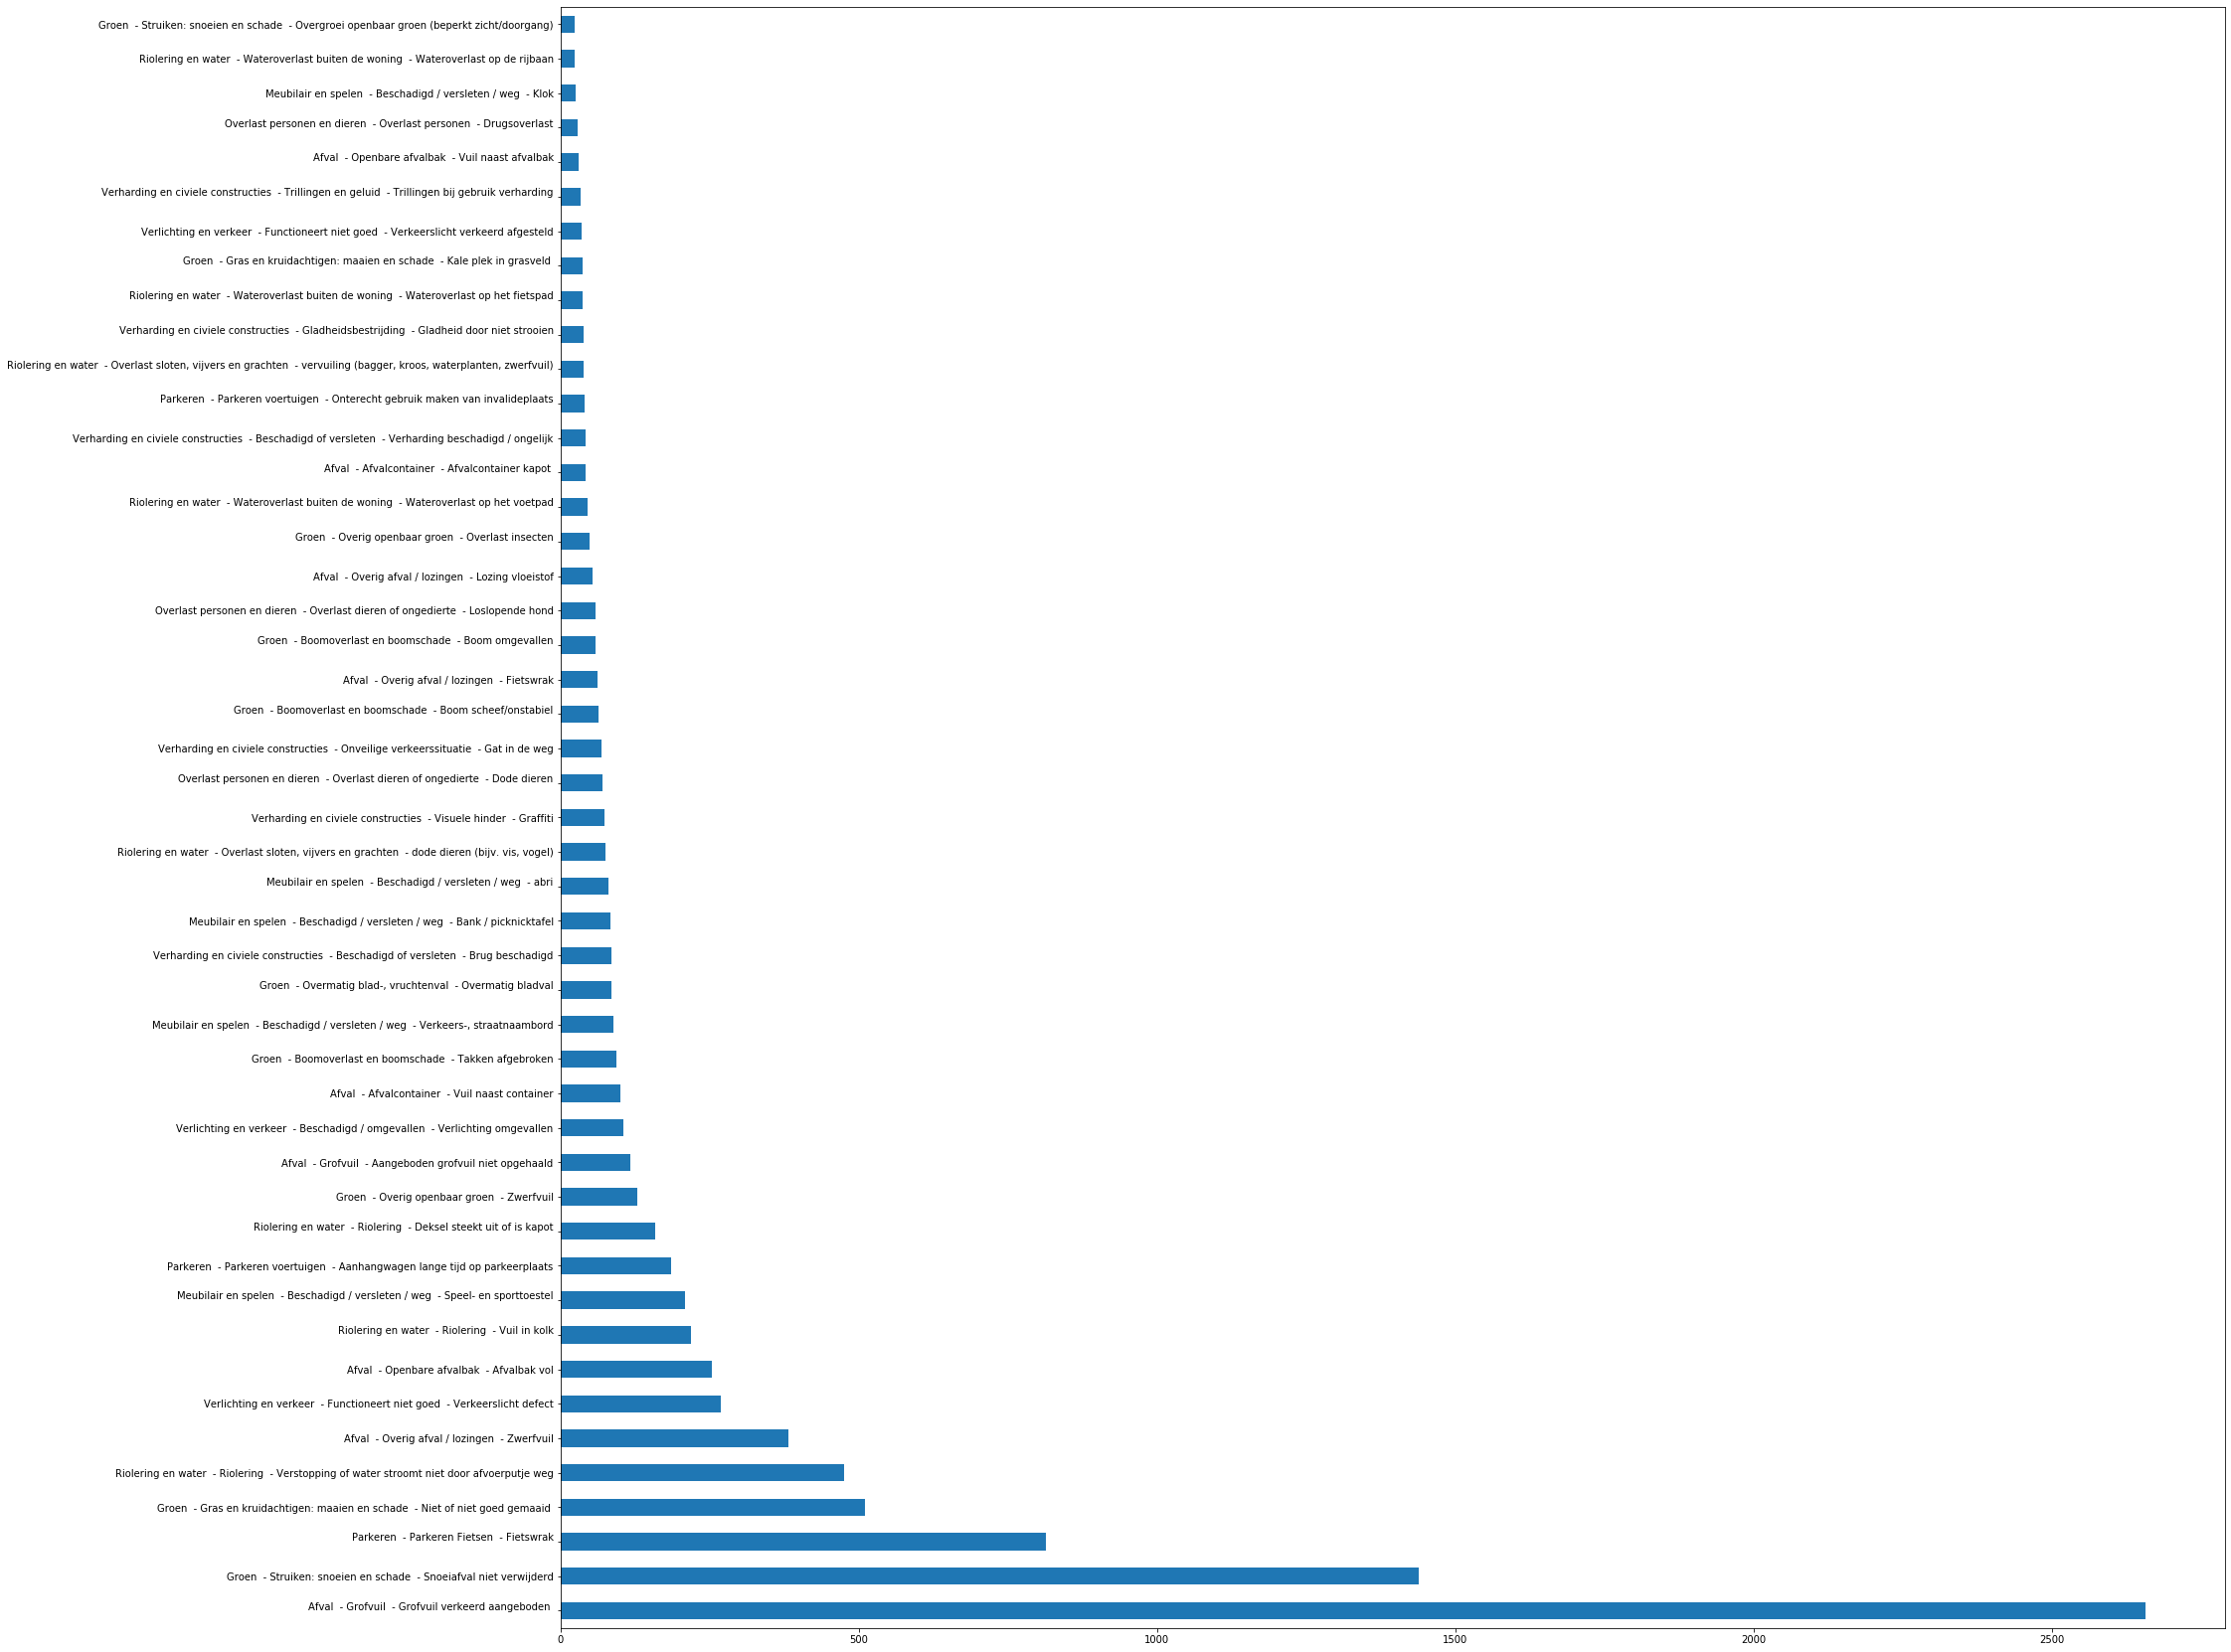

In [17]:
import pandas as pd

df = pd.read_csv(trainingsset, engine='python')
df.head()
df = df[["omschrijving", "bor_meld"]]
df = df.rename(columns={"omschrijving": "Text", "bor_meld": "Label"})

df = df.dropna(axis=0, how='any', thresh=None, subset=['Text', 'Label'], inplace=False)
print(len(df),'rows classified and with description') 

# cleanup dataset
df = df.drop_duplicates(subset=['Text'], keep='first')
# for dev use only a subset (for speed purpose)
# frac .099 will randomize the set as well
df = df.sample(frac=0.99).reset_index(drop=True)

#drop categories below 50 is recommended for realtime predictions. 
#for buidling the model > 10 is required (with warnings in evaluative functions)
cutoff = 20
number_of_examples = df['Label'].value_counts().to_frame()
df['is_bigger_than_'+ str(cutoff)] = df['Label'].isin(number_of_examples[number_of_examples['Label']>(cutoff)].index)
df['is_bigger_than_'+ str(cutoff)].value_counts()
df = df[df['is_bigger_than_'+ str(cutoff)] == True]
print(len(df),'rows with more then ' + str(cutoff)+ ' items per class no duplicates') # The example dataset is not large enough to train a good classification model


texts = df['Text']
labels = df['Label']

# Splitting data
split = 0.5
splitpoint = int(split*len(texts))

# train data
train_texts = texts[:splitpoint]
train_labels = labels[:splitpoint]

# test data
test_texts = texts[splitpoint:]
test_labels = labels[splitpoint:]

# visualize data distribution
labels.value_counts().plot(kind='barh').get_figure().savefig('dist.pdf')




# Stopwoorden
Stopwoorden verwijderen leveren ongeveer een 1% verbetering van de F1 op.
'Naast' is een veel voorkomend stopwoord dat niet in het gebruikte woordenboek voor stopwoorden staat. Dit  ivm 'vuil naast container', die wordt dus gewoon meegenomen.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

import warnings

from nltk.stem.snowball import DutchStemmer
import nltk
nltk.download('stopwords')
# init stemmer
stemmer=DutchStemmer(ignore_stopwords=True)

stop_words = set(nltk.corpus.stopwords.words('dutch'))
#print(stop_words)

import re
re_userid = re.compile("^([a-z]+\\:)")
def simple_preprocessor(text):
    text=text.lower()
    # text=re.sub(re_userid," ", text) # remove user name id
    text=re.sub("\\W"," ",text) # remove special chars
    
    # stem words
    words=re.split("\\s+",text)
    stemmed_words=[stemmer.stem(word=word) for word in words]
    return ' '.join(stemmed_words)

warnings.simplefilter(action='ignore', category=FutureWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ajslaghu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:

pipeline = Pipeline([
        #('vect', CountVectorizer(stop_words=stop_words)),
        ('vect', CountVectorizer(preprocessor=simple_preprocessor, stop_words=stop_words)),
     # ('vect', CountVectorizer(preprocessor=simple_preprocessor)),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression()),
])

# multiple hyperparameters, slow training, better optimization
parameters_slow = {
        'clf__class_weight': (None,'balanced'), #"balanced",
        'clf__max_iter': (300,500),  #500,1000
        'clf__penalty': ('l1',), #'l2',
        'clf__multi_class': ('auto',),
        'clf__solver': ('liblinear',), # lbfgs
        'tfidf__norm': ('l2',), # 'l1'
        'tfidf__use_idf': (False,),
        'vect__max_df': (1.0,),
        'vect__max_features': (None,),
        'vect__ngram_range': ((1, 1), )# (1,2)
}

grid_search = GridSearchCV(pipeline, parameters_slow,verbose=True,n_jobs=2,cv=3)
grid_search.fit(train_texts, train_labels)

print('Best parameters: ')
print(grid_search.best_params_)
print('')

print('Best score: ')
print(grid_search.best_score_)
print('')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    7.3s finished


Best parameters: 
{'clf__class_weight': None, 'clf__max_iter': 300, 'clf__multi_class': 'auto', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__ngram_range': (1, 1)}

Best score: 
0.7476269298756502



# Model persistence
http://scikit-learn.org/stable/modules/model_persistence.html

Saving the model to be able to use it for making predictions later.

In [21]:
# from sklearn.externals import joblib
import joblib
joblib.dump(grid_search, modelfile) 

model = joblib.load(modelfile) 
print('model saved to disk')

model saved to disk


# Evaluation

Evaluation using precision, recall and accuracy

Precision 0.8
Recall 0.56
Accuracy 0.79


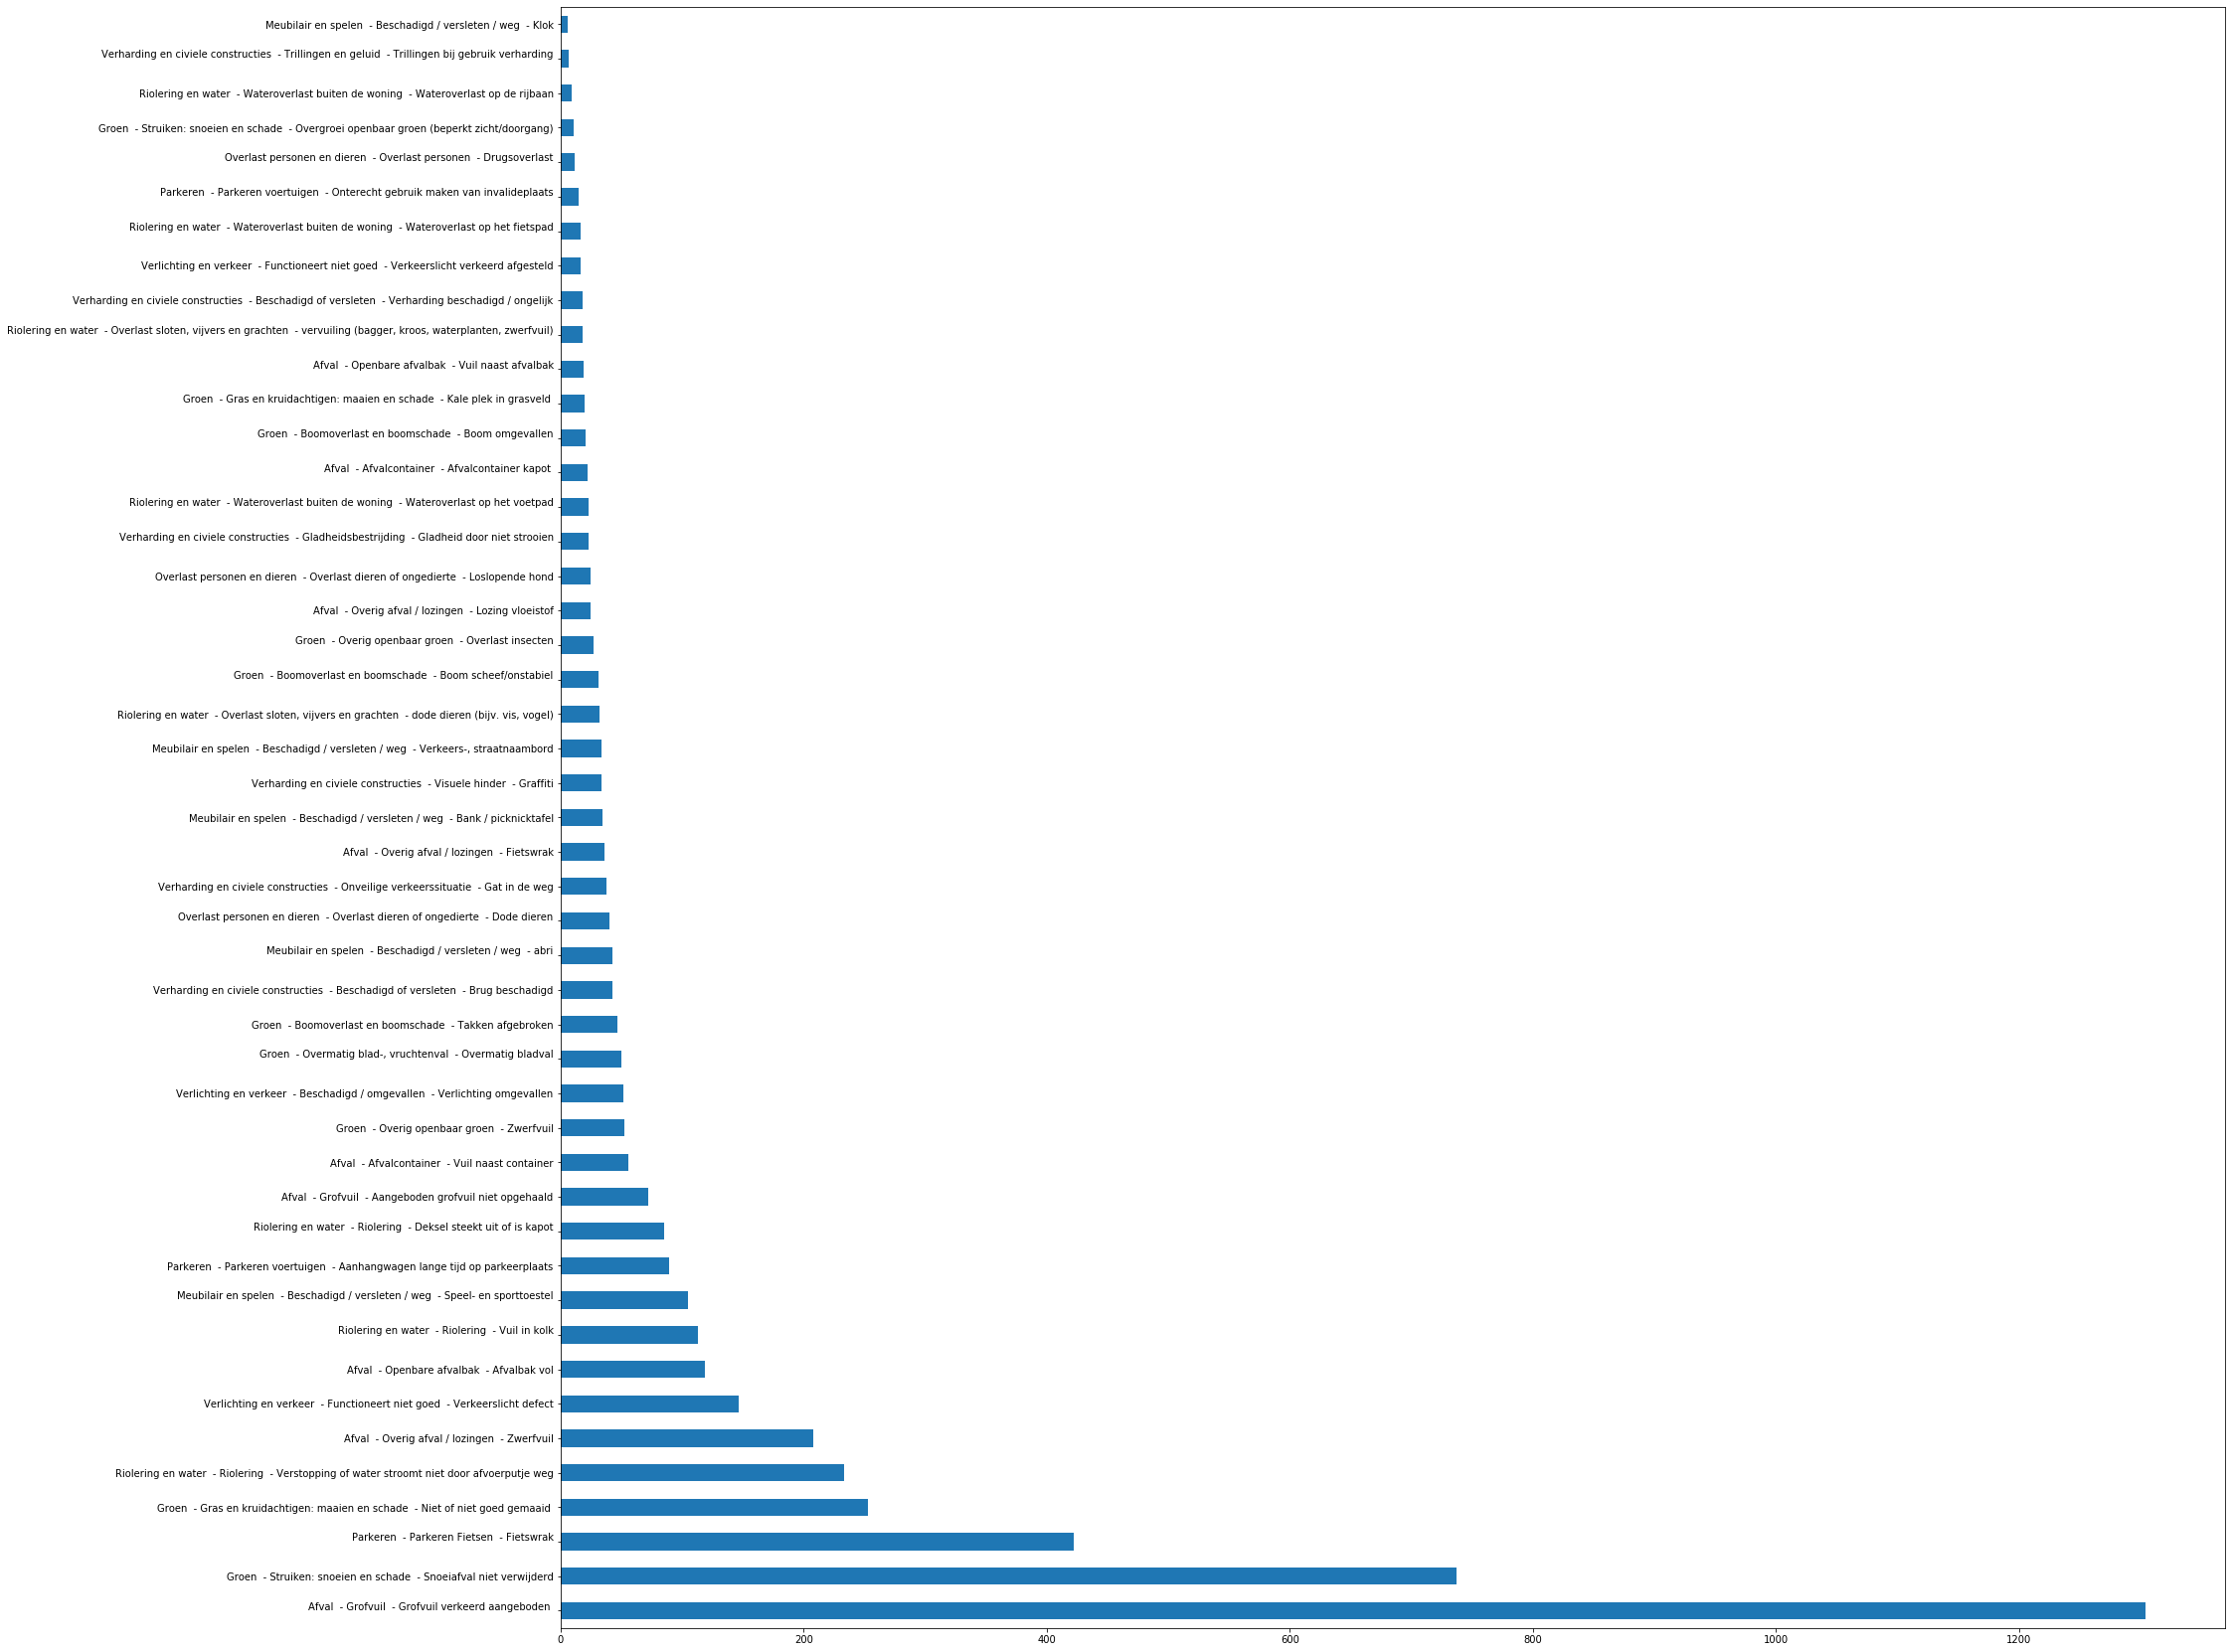

In [22]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

test_predict = model.predict(test_texts)

precision = str(round(precision_score(test_labels, test_predict, average='macro', zero_division=0),2))
recall = str(round(recall_score(test_labels, test_predict, average='macro'),2))
accuracy = str(round(accuracy_score(test_labels, test_predict),2))

print('Precision', precision)
print('Recall', recall)
print('Accuracy', accuracy)

test_labels.value_counts().plot(kind='barh')

# Evaluate algorithm

Voor BOR MELD  werken ongeveer 37 categorieen prima. 64 categorieen zijn niet veelvoorkomend (1700 van de 9642) maar wel problematisch. 17% van de foutmarge komt hier uit voort. 8% uit voorspelfouten van de beste 37 categorieen. Van de slecht voorspelbare categorieen is de support maximaal 162 items bij (  Afval  - Overig afval / lozingen  - Zwerfvuil ). Door het BOR MELD model aan te passen zou zwerfvuil beter geclassificeerd kunnen worden.  Goedwerkende categorie met de laagste aantal items  12 (licht brand overdag) geeft aan kleine categorieen niet erg zijn, als ze maar niet samenvallen met andere categorieen.


In [23]:
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

classificationfile = open("classification_report.txt","w+")  
rp = classification_report(test_labels, test_predict, labels=test_labels, output_dict=False) 

print(classification_report(test_labels, test_predict, labels=test_labels),file = classificationfile )

print("report saved")
classificationfile.close()

warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"


report saved


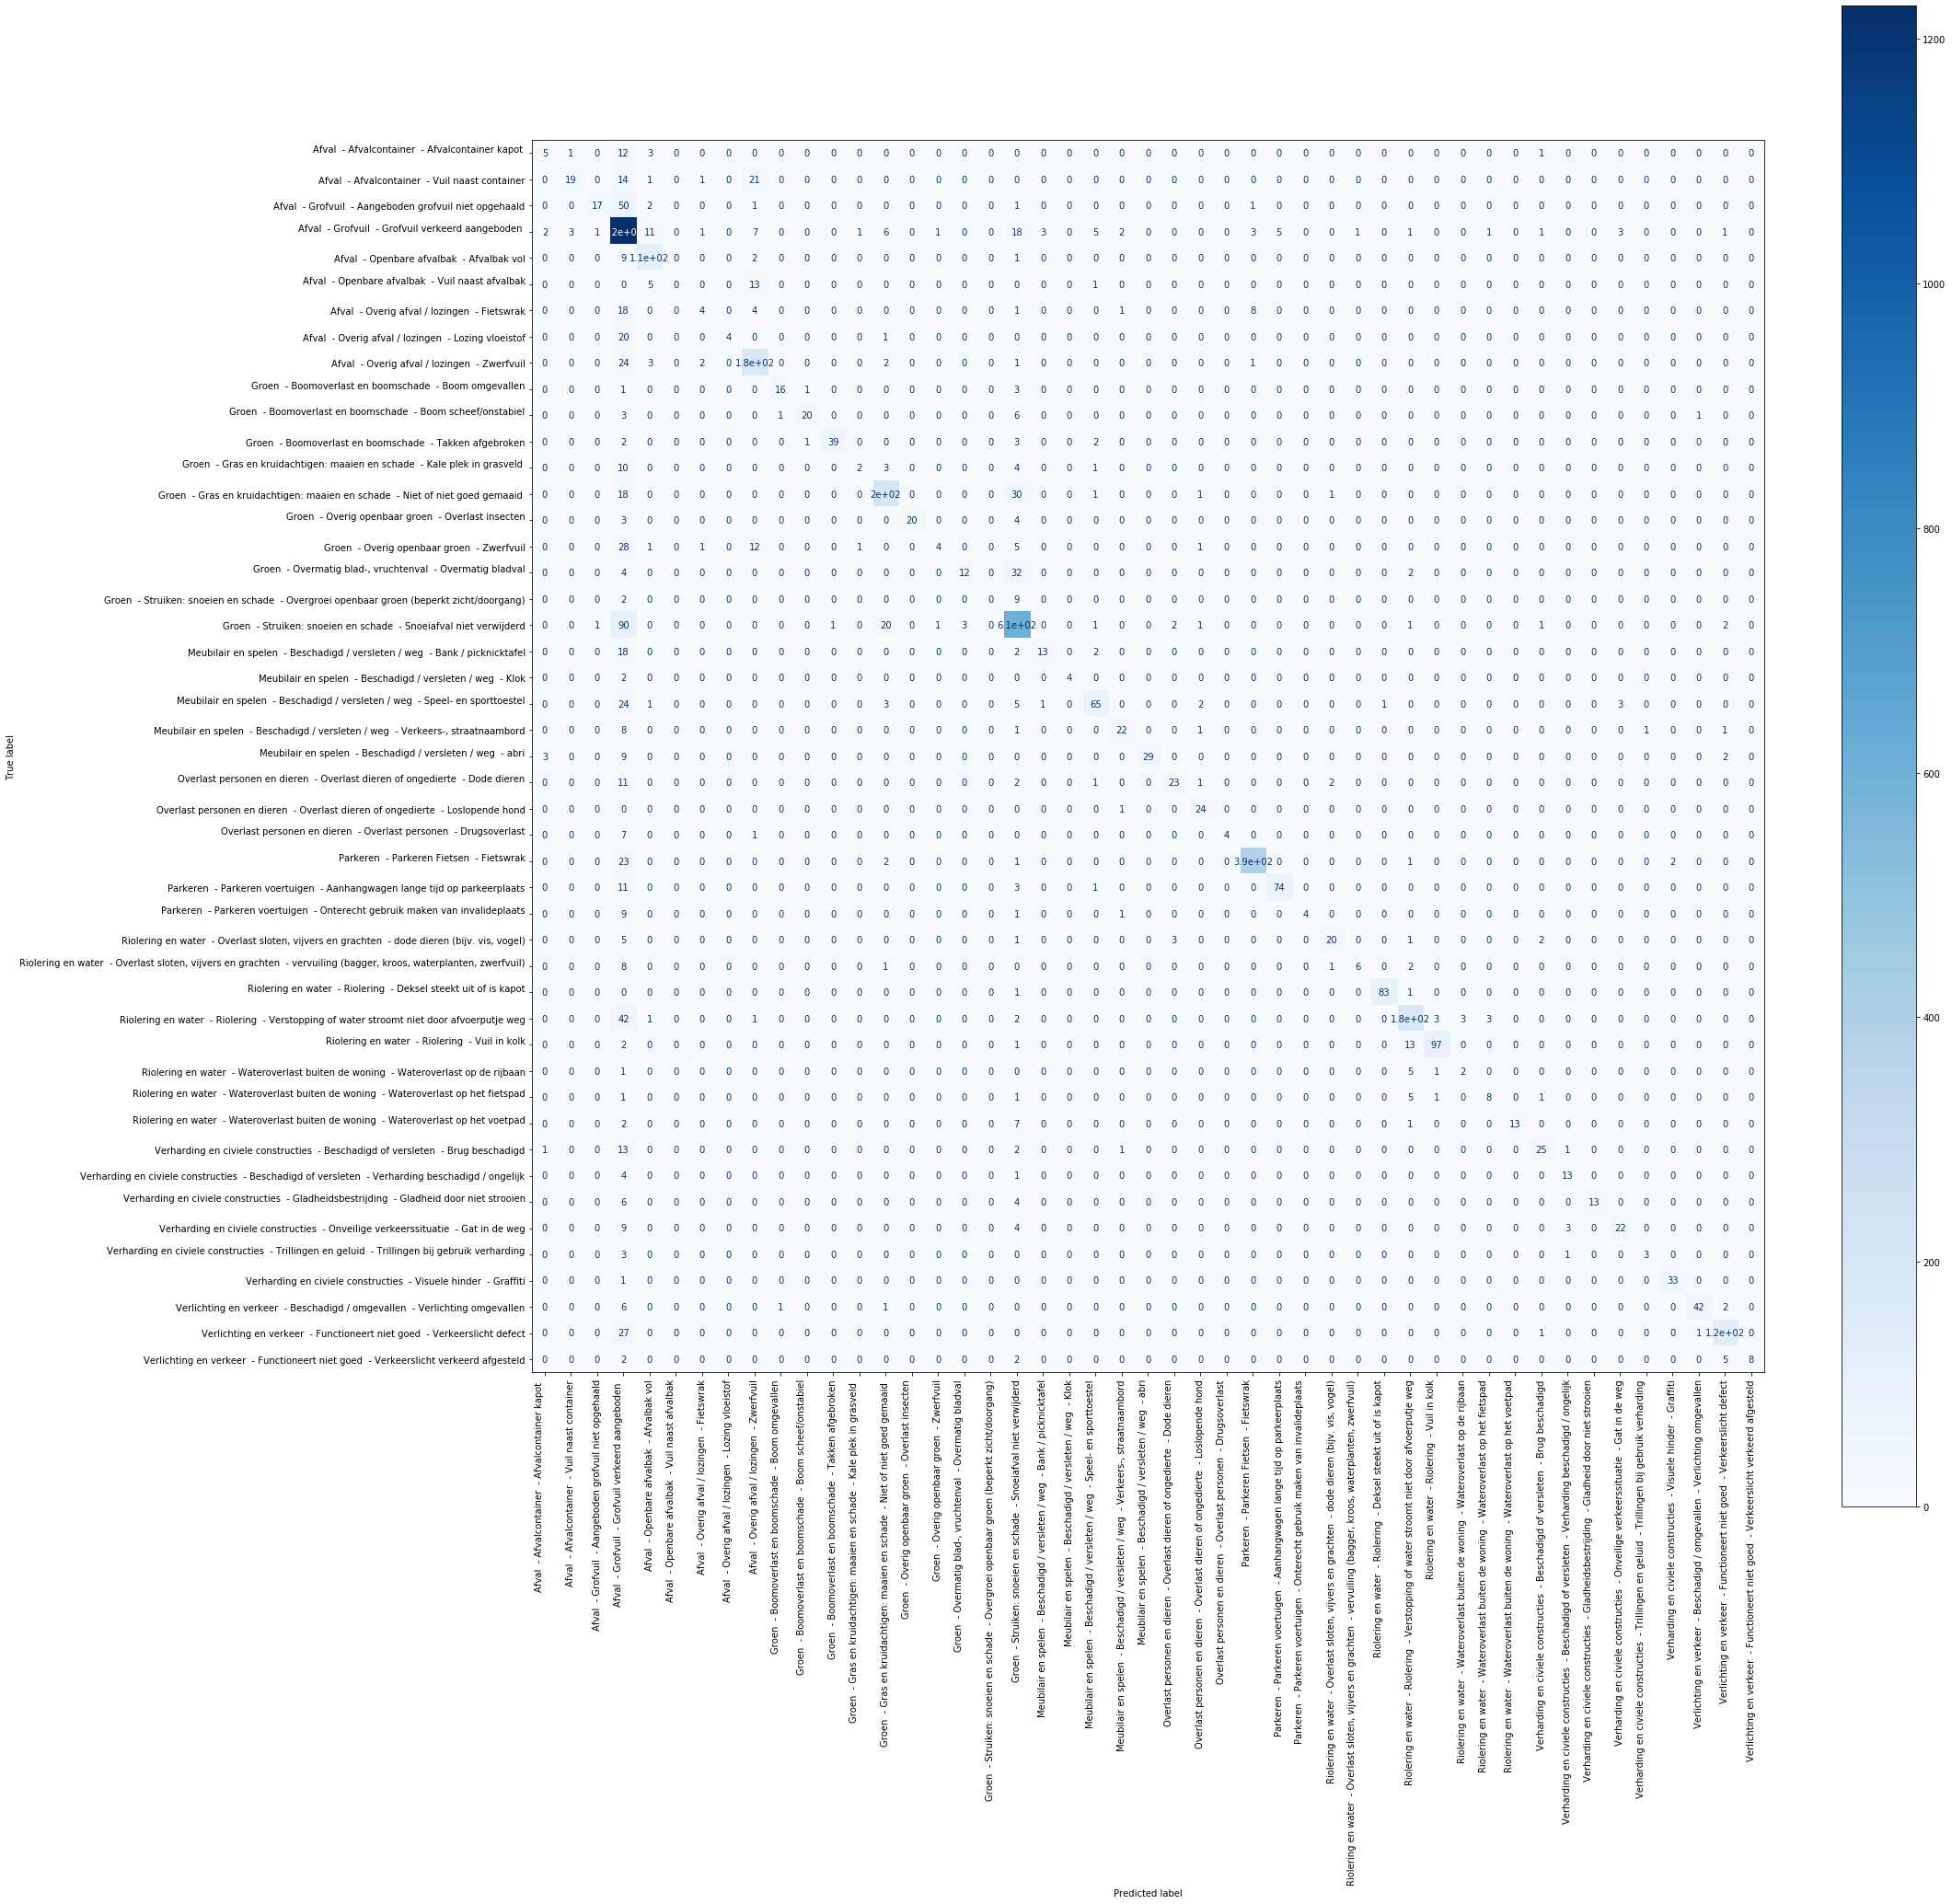

In [24]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,30)

disp = plot_confusion_matrix(model, test_texts, test_labels,
                                 #display_labels=display_labels,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                 xticks_rotation='vertical')
plt.savefig("mat.pdf")
plt.show()


In [25]:
# show mispredicted items
mispred = open('mispred.csv', 'w') 
print('omschrijving,', 'predicted,', ' actual,', 'improve' '\n', file = mispred)
count =0;
preds=0;
for input, prediction, label in zip(test_texts, test_predict, test_labels):
  preds = preds + 1  
  if prediction != label:
    print("\"" + input + "\"," , "\"" + prediction + "\"," , "\"" + label +"\"," , file = mispred)
    count = count +1
mispred.close()
print('counted mispredictions ' + str(count) + ' | records predicted ' + str(preds) )


counted mispredictions 1021 | records predicted 4846


In [26]:

print(model.predict_proba(['afval naast container gedumpt']))


[[1.34400514e-02 5.64909954e-02 2.15146612e-02 7.66217181e-01
  2.67697021e-03 1.13833402e-03 2.58249687e-03 3.57135483e-03
  1.04720421e-04 1.02932825e-03 5.22553546e-04 9.14845896e-04
  1.71319630e-03 9.96061878e-04 2.29096300e-03 6.66429265e-02
  1.88626062e-03 1.99047150e-03 1.91968124e-03 1.97149573e-03
  1.32281842e-03 1.94674065e-03 3.48095098e-03 1.33571207e-03
  1.45746017e-03 1.26005882e-03 2.20410600e-03 5.24061350e-04
  2.58250307e-03 2.22824291e-03 1.88139807e-03 2.53374561e-03
  1.44517845e-03 3.41316059e-03 2.86866217e-03 1.20564781e-03
  6.89623375e-04 1.42956792e-03 2.11996883e-03 1.94719930e-03
  1.45600476e-03 9.35747129e-04 2.14685931e-03 1.80637701e-03
  1.33764203e-03 3.56174108e-03 1.26427204e-03]]


In [27]:
print(model.predict(['afval naast container gedumpt']))

['Afval  - Grofvuil  - Grofvuil verkeerd aangeboden \n']
